In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import constants
from math import sin, cos

# for reference
# IMG_WIDTH = 2048 - 512
# IMG_HEIGHT = IMG_WIDTH // 16 * 5
# MODEL_SCALE = 8
# # Original Image shape
# IMG_SHAPE = (2710, 3384, 3)

Image loaded. Input to entire model


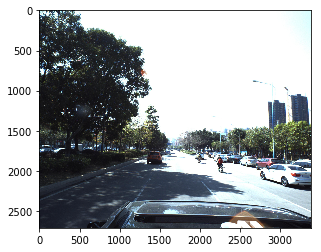

Shape is (height,width,channels) (2710, 3384, 3)


In [2]:
print("Image loaded. Input to entire model")
img=cv2.imread('..\\basement-scientists\\pku-auto-drive\\train_images\\ID_00ab59fa6.jpg')
img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.show()
print("Shape is (height,width,channels)",img.shape)

In [3]:
def preprocess_image(img, flip=False):
    # lets see if this works
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 6]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (constants.IMG_WIDTH, constants.IMG_HEIGHT))
    if flip:
        img = img[:,::-1]
    # guassian blur the image
    img = cv2.GaussianBlur(img,(3,3),0)
    return (img / 255).astype('float32')

Input to Myconv model. Flip = false


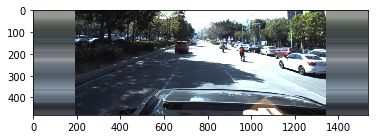

Shape is (height,width,channels) (480, 1536, 3)


In [4]:
print("Input to Myconv model. Flip = false")
img_pre= preprocess_image(img, flip=False)
plt.imshow(img_pre)
plt.show()
print("Shape is (height,width,channels)",img_pre.shape)

Input to Myconv model. Flip = True


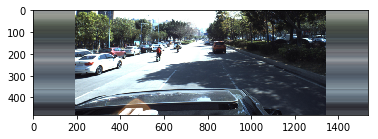

Shape is (height,width,channels) (480, 1536, 3)


In [5]:
print("Input to Myconv model. Flip = True")
img_pre= preprocess_image(img, flip=True)
plt.imshow(img_pre)
plt.show()
print("Shape is (height,width,channels)",img_pre.shape)

Input to Efficient Net B0 model


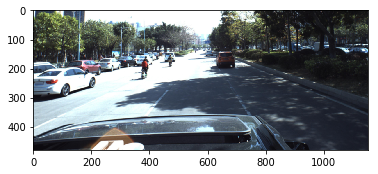

Shape is (height,width,channels) (480, 1152, 3)


In [7]:
print("Input to Efficient Net B0 model")
img_center =img_pre[ :, constants.IMG_WIDTH // constants.MODEL_SCALE: -constants.IMG_WIDTH // constants.MODEL_SCALE, :]
plt.imshow(img_center)
plt.show()
print("Shape is (height,width,channels)",img_center.shape)

In [8]:
train_df = pd.read_csv('..\\basement-scientists\\pku-auto-drive\\train.csv')

In [9]:
train_df

,ImageId,PredictionString
0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1,ID_337ddc495,66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2,ID_a381bf4d0,43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3,ID_7c4a3e0aa,43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4,ID_8b510fad6,37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...
...,...,...
4257,ID_de17ab626,70 0.177583 -0.023215 -3.08003 -25.3682 7.5732...
4258,ID_5a669e211,12 0.23817 -3.12745 3.13929 -7.21988 3.09626 1...
4259,ID_aa6ffba0a,35 0.166437 -0.497963 -3.12063 12.6792 5.48256...
4260,ID_29454123f,70 0.14292 0.0290822 -3.12594 -3.42749 3.38674...


In [10]:
labels=train_df.loc[train_df['ImageId']=='ID_00ab59fa6'].values[0][1]

In [11]:
labels

'28 0.165604 0.00980352 -3.09226 8.85067 4.36359 14.8608 16 0.17617 -0.0102396 -3.09429 11.1604 6.31544 27.8312 28 0.135123 0.0901037 3.13002 12.137 7.89515 37.0651 16 0.155728 0.000714415 -3.11115 8.60718 7.34444 35.0384 54 0.237026 -0.0186688 -3.00807 13.0395 12.9287 65.8691 50 0.175619 -0.0348313 -3.09083 -2.93342 5.89743 28.8572 51 0.172864 -8.871e-05 -3.08325 13.7128 6.56594 27.0991 46 0.155728 0.171116 -3.11115 17.0052 12.3741 60.3344 46 0.237026 0.0276678 -3.00807 14.0783 13.0987 65.6462 2 0.237025 0.0638916 -3.00807 5.31823 8.1412 41.5245 16 0.17562 0.0229946 -3.09084 -2.22178 10.6927 59.3069 7 0.180463 -1.50629 -3.11271 -36.8992 16.5314 103.455 16 0.180459 3.1355 -3.11272 -25.7637 6.48508 36.6539'

In [12]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

def get_img_coords(s, camera_matrix):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

def _regr_preprocess(regr_dict, flip=False):
    if flip:
        for k in ['x', 'pitch', 'roll']:
            regr_dict[k] = -regr_dict[k]
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict


def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x


def get_mask_and_regr(img, labels, flip=False):
    IMG_WIDTH = constants.IMG_WIDTH
    MODEL_SCALE = constants.MODEL_SCALE
    IMG_HEIGHT = constants.IMG_HEIGHT

    # image height, image width, model scale 
#     IMG_WIDTH = 2048 - 512
#     IMG_HEIGHT = IMG_WIDTH // 16 * 5
#     MODEL_SCALE = 8
#     # Original Image shape
#     IMG_SHAPE = (2710, 3384, 3)
    
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    print("mask initial shape",mask.shape)
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    print("regr Initial shape",regr.shape)
    coords = str2coords(labels)
    print("cords shape",len(coords))
    print("cords\n",coords)
    xs, ys = get_img_coords(labels, constants.CAMERA_MATRIX)
    print("xs shape",xs.shape)
    print("xs\n",xs)
    print("ys shape",ys.shape)
    print("ys\n",ys)
    for x, y, regr_dict in zip(xs, ys, coords):
        # swapping x and y
        x, y = y, x
        x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + img.shape[1] // 6) * IMG_WIDTH / (img.shape[1] * 4/3) / MODEL_SCALE
        y = np.round(y).astype('int')
        # checking if its in the downgraded image 
        # but why divide by scale
        if x >= 0 and x < IMG_HEIGHT // MODEL_SCALE and y >= 0 and y < IMG_WIDTH // MODEL_SCALE:
            mask[x, y] = 1
            print("regr_dict shape before preprocess",len(regr_dict))
            print("regr_dict before preprocess\n",regr_dict)  
            regr_dict = _regr_preprocess(regr_dict, flip)
            print("regr_dict shape after preprocess",len(regr_dict))
            print("regr_dict after preprocess\n",regr_dict)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    if flip:
        mask = np.array(mask[:,::-1])
        regr = np.array(regr[:,::-1])
    return mask, regr

In [13]:
mask, regr=get_mask_and_regr(img, labels)
regr = np.rollaxis(regr, 2, 0)

mask initial shape (60, 192)
regr Initial shape (60, 192, 7)
cords shape 13
cords
 [{'id': 28, 'z': 14.8608, 'pitch': 0.00980352, 'roll': -3.09226, 'x': 8.85067, 'yaw': 0.165604, 'y': 4.36359}, {'id': 16, 'z': 27.8312, 'pitch': -0.0102396, 'roll': -3.09429, 'x': 11.1604, 'yaw': 0.17617, 'y': 6.31544}, {'id': 28, 'z': 37.0651, 'pitch': 0.0901037, 'roll': 3.13002, 'x': 12.137, 'yaw': 0.135123, 'y': 7.89515}, {'id': 16, 'z': 35.0384, 'pitch': 0.000714415, 'roll': -3.11115, 'x': 8.60718, 'yaw': 0.155728, 'y': 7.34444}, {'id': 54, 'z': 65.8691, 'pitch': -0.0186688, 'roll': -3.00807, 'x': 13.0395, 'yaw': 0.237026, 'y': 12.9287}, {'id': 50, 'z': 28.8572, 'pitch': -0.0348313, 'roll': -3.09083, 'x': -2.93342, 'yaw': 0.175619, 'y': 5.89743}, {'id': 51, 'z': 27.0991, 'pitch': -8.871e-05, 'roll': -3.08325, 'x': 13.7128, 'yaw': 0.172864, 'y': 6.56594}, {'id': 46, 'z': 60.3344, 'pitch': 0.171116, 'roll': -3.11115, 'x': 17.0052, 'yaw': 0.155728, 'y': 12.3741}, {'id': 46, 'z': 65.6462, 'pitch': 0.0276

Input image


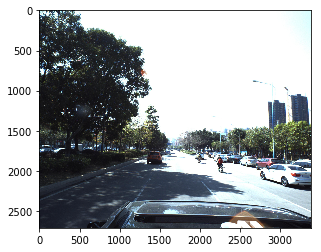

Mask represents the centers
Mask. Shape is (60, 192)
Number of White spots (13,)
ranges from min: 0.0 to 1.0


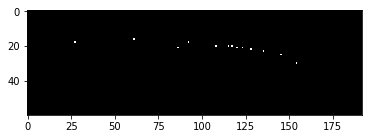

In [14]:
print("Input image")
plt.imshow(img)
plt.show()

print("Mask represents the centers")
print("Mask. Shape is",mask.shape)
print("Number of White spots",mask[(mask!=0)].shape)
print("ranges from min:",np.min(mask),"to",np.max(mask))
plt.imshow(mask,cmap='gray')
plt.show()

Regr. Shape is (7, 60, 192)
Number of Non zero spots in
regr 0 is (13,) ranges from min: -0.99998146 to 1.0
regr 1 is (13,) ranges from min: -0.9979202 to 0.17028216
regr 2 is (13,) ranges from min: -0.011572653 to 0.13352266
regr 3 is (13,) ranges from min: -0.368992 to 0.170052
regr 4 is (13,) ranges from min: 0.0 to 0.165314
regr 5 is (13,) ranges from min: 0.0 to 0.237026
regr 6 is (13,) ranges from min: 0.0 to 1.03455


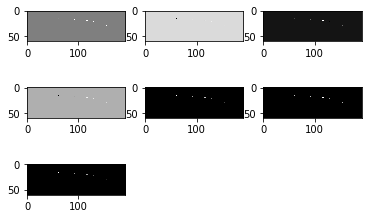

In [15]:
print("Regr. Shape is",regr.shape)
print("Number of Non zero spots in")
# this is because only these thirteen points should have the values as they represent cars
for i in range(regr.shape[0]):
    print("regr",i,"is",regr[i][(regr[i]!=0)].shape,"ranges from min:",np.min(regr[i]),"to",np.max(regr[i]))
    plt.subplot(3,3,i+1)
    plt.imshow(regr[i],cmap='gray')
plt.show()